<a href="https://colab.research.google.com/github/iciromaco/RadiShLab/blob/master/S2_%E3%82%B7%E3%83%AB%E3%82%A8%E3%83%83%E3%83%88%E7%94%BB%E5%83%8F%E3%81%AE%E7%94%9F%E6%88%90_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ローカルランタイムで実行する場合
```jupyter notebook  --NotebookApp.allow_origin='https://colab.research.google.com'  --port=8888```


### Google Colaboratory で実行する場合
次のセルを実行し、表示されたリンク先にアクセスし、接続を許可します。表示されたコードを枠内にペーストしてEnterすると、左のエリアに drive というフォルダが現れます。このフォルダ内の My Drive は自分の Google Drive そのものです。

Google Colab では作成した notebook は Google Drive の「Colab notebook」というフォルダに残りますが、それ以外のすべてのファイルはその場限りで消されれてしまいますが、Google Drive を保存先にしておけば消されずに残ります。

大量のデータをアップロードするのも、Google Drive を使うのが便利です。


In [0]:
import sys
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append('/content/drive/My Drive/RadishLab')
    COLABORATORY = True
except ImportError:
    COLABORATORY = False
import rdlib4 as rd

In [0]:
# サンプルの画像フォルダのパス (Colab)
if COLABORATORY:
    DATAFOLDER = '/content/drive/My Drive/RadishLab/RDSamples'
else:
    DATAFOLDER = 'RDSamples'
# 指定フォルダ内の画像を収集
imgs = rd.collectimages(DATAFOLDER)

# (8) RDreform()　ガウスぼかし、膨張収縮、輪郭近似で形状を整える関数 

画像中で大根の主要部が一番大きな白領域である場合は、 RDreform()関数のデフォルトでシルエット画像が生成できる

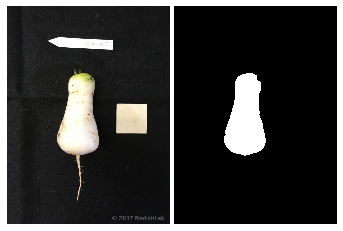

In [4]:
rd.plotimg(rd.mkparaimage2(imgs[0],rd.RDreform(imgs[0])))

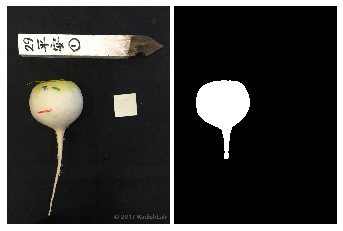

In [5]:
rd.plotimg(rd.mkparaimage2(imgs[1],rd.RDreform(imgs[1])))

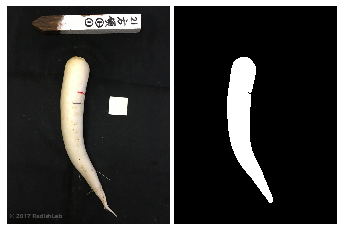

In [6]:
rd.plotimg(rd.mkparaimage2(imgs[2],rd.RDreform(imgs[2])))

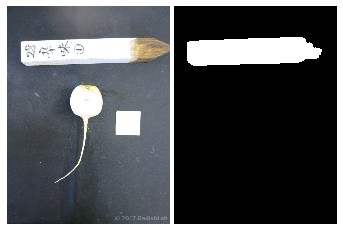

In [7]:
rd.plotimg(rd.mkparaimage2(imgs[4],rd.RDreform(imgs[4])))

デフォルトでは一番大きな白領域を取り出している。この例では杭が一番おおきいために杭が取り出されてしまっている。

このような場合には、取り出したい領域の面積順位を order=2 という風に明示的に与える。

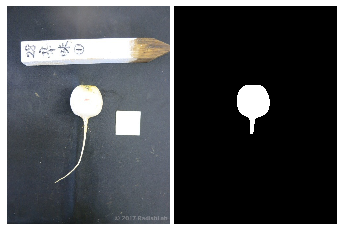

In [8]:
rd.plotimg(rd.mkparaimage2(imgs[4],rd.RDreform(imgs[4],order=2)))

# (9) GrabCut による大根の切り出し　getRadish()

getRadish() は GrabCut という手法を用いて、カラー画像中の１つの大根領域を抽出する関数である。

RDreform は画像全体で２値化のしきい値を決める。画像中には指標なども映り込んでいるので、場合によってはしき値が適切に選べずに、きれいに切り出せないこともありうる。

そのような場合、GrabCut によるセグメンテーションが有効でである。

GrabCut は、前景と背景がなるべく不連続であり、境界部のそれぞれの領域は連続的であり、かつ前景はただひとつの連続する輪郭を持つように画像を分離する手法である。

RDrefom() をいきなり使った場合よりも、GrabCut で大根部分だけを切り出してから RDreform() を使ったほうが、質のよいシルエットを生成できるだろう。


In [9]:
img  = imgs[0]
gcimg = rd.getRadish(img)
bwimg,b = rd.RDreform(gcimg)
plt.figure(dpi=150)
rd.plotimg(rd.mkparaimage([img,gcimg,bwimg,b]))

error: ignored

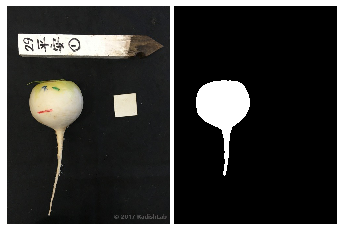

In [11]:
img = imgs[1]
rd.plotimg(rd.mkparaimage2(img,rd.RDreform(img,ksize=0,shrink=0.9,order=1)))

In [12]:
gcimg = getRadish(img,1)
bwimg = RDreform(gcimg,ksize=0,shrink=0.9)
plt.figure(dpi=150)
rd.plotimg(rd.mkparaimage([img,gcimg,bwimg]))

NameError: ignored

In [0]:
m1,m2 = mkGCmask(img,thickness=5, order=1)

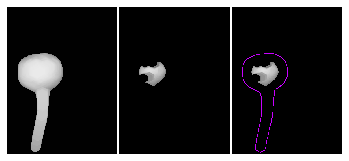

In [23]:
rd.plotimg(rd.mkparaimage([-m1,m2,rd.draw2(-m1,m2)]))

In [0]:
# (9) Grabcut による大根領域の抜き出し
def mkGCmask(img,thickness=5, order=1):
    # カラー画像の場合はまずグレー画像に変換
    if img.ndim == 3:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy() # 副作用はないと思うが、念のため

    # 大きめのガウシアンフィルタでぼかした後に大津の方法で２階調化
    ksize = rd.calcksize(gray) # RDForm で使う平滑化のカーネルサイズ
    bsize = ksize # 
    blur = cv2.GaussianBlur(gray,(bsize,bsize),0)  # ガウスぼかし                        
    coreimg = rd.getMajorWhiteArea(blur,order) # ２値化して一番大きな領域だけ抽出
    
    # 膨張処理で確実に背景である領域をマスク
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(ksize,ksize)) # 円形カーネル
    mask1 = 255-cv2.dilate(coreimg,kernel,iterations = ksize+5)
    
    # 収縮処理で確実に内部である領域をマスク
    mask2 = cv2.erode(coreimg,kernel,iterations = ksize+5)

    return mask1,mask2

def getRadish(img,order=1):
    # 白領域の面積が order で指定した順位の領域を抜き出す

    mask1,mask2 = mkGCmask(img)

    # grabcut　用のマスクを用意 
    grabmask = np.ones(img.shape[:2],np.uint8)*2
    # 
    grabmask [mask1==255]=0     # 黒　　背景　　
    grabmask [mask2==255]=1    # 白　前景
    
    # grabcut の作業用エリアの確保
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    # MASK による grabcut 実行
    grabmask, bgdModel, fgdModel = cv2.grabCut(img,grabmask,None,bgdModel,fgdModel,20,cv2.GC_INIT_WITH_MASK)
    grabmask = np.where((grabmask==2)|(grabmask==0),0,1).astype('uint8')
    grabimg = img*grabmask[:,:,np.newaxis]

    return grabimg

In [0]:
CONTOURS_APPROX=0.0002
a = RDreform(gcimg,ksize=0,shrink=SHRINK,order=1)
b = RDreform(gcimg,ksize=0,shrink=SHRINK,order=1,dilation=20)

In [0]:
a.shape

In [0]:
plt.figure(dpi=200)
rd.plotimg(rd.mkparaimage2(a,b))

In [0]:
b

In [0]:
plt.imshow(b)